# Installation and System Check

Installing the transformers library and checking GPU availability.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 23.6MB/s 
     |████████████████████████████████| 3.3MB 49.5MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 


In [ ]:
import numpy as np

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Data Pre-processing

## Reading train

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

Version 2: keep headers

In [ ]:
newsgroups_train = fetch_20newsgroups(remove=('footers', 'quotes'), subset='train')

In [ ]:
df = pd.DataFrame()
df['data'] = newsgroups_train['data']
df['target'] = newsgroups_train['target']

## Read All

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

Change: headers removed

In [ ]:
newsgroups = fetch_20newsgroups(remove=('footers', 'quotes'), subset='all')

In [ ]:
df = pd.DataFrame()
df['data'] = newsgroups['data']
df['target'] = newsgroups['target']

## Train/Validation/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
df['target'].value_counts()

14    913
8     910
10    904
15    898
3     896
13    891
9     890
5     888
7     887
11    886
6     877
12    875
2     874
1     871
4     859
17    850
16    817
0     726
18    696
19    553
Name: target, dtype: int64

## Cleaning

Deleting special characters from the text documents.


In [ ]:
df['data'] = df['data'].apply(lambda x: x.replace("\n", "").replace("-", "").replace("....", "")) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Deleting missing values.

In [ ]:
df = df.drop(df[df['data']==''].index)

### Splitting the documents into *n* equal parts

Defined functions:


*   **split_doc**: splits the document into *n* equal parts based on the **threshold** (number of words) and returns the the list of shorter documents
*   **count_len**: returns the number of documents where the word count exceeds the given threshold
*   **split_df**: splits the documents in the *data* column of a dataframe based on a given **threshold** (number of words) and returns the splitted parts of the document while saving a list of indeces which need to be removed (records which exceed the threshold)



In [ ]:
def split_doc(document, threshold):
    #split the document into words
    splitted_doc = document.split()
    #doc length
    length_original = len(splitted_doc)
    length = length_original
    n_groups = length // threshold
    n_words = length // (n_groups + 1) 
    s = ' '
    result = []
    i = 0
    while length > 0:
        if length >= n_words:
            new_doc = [splitted_doc[j] for j in range(i*n_words, i*n_words + n_words)]
            result.append(s.join(new_doc))
            length = length - n_words
        else:
            new_doc = [splitted_doc[j] for j in range(i*n_words, length_original)]
            result.append(s.join(new_doc))
            length = 0

        i = i + 1
    return result

In [ ]:
def count_len(df, threshold):
    count = 0
    for index, row in df.iterrows():
        if len(row['data'].split())>threshold:
            count = count + 1
            #print(len(row['data'].split()))
    return count

In [ ]:
def split_df(dataframe, threshold):

    index_list = []
    data = []
    for index, row in dataframe.iterrows():
        if len(row['data'].split())>threshold:
            splitted_doc_list = split_doc(row['data'], threshold)
            target = row['target']
            for doc in splitted_doc_list:
                data.append({'data': doc, 'target': target})
            index_list.append(index)
    return index_list, data           
    

In [ ]:
threshold = 150
index_list, data = split_df(df, threshold)
df = df.drop(index_list)
df = df.append(data, True)


In [ ]:
count_len(df, 200)

0

### Filtering encoded documents

There are some encoded documents in the data set which need to be filtered. These will be filtered based on the ratio between the number of characters and number of words in the documents. This ratio is around 5 in the english language.

Defined functions:


*   **chars_for_words**: returns a Boolean value which is **True** if the ratio for the given document is above threshold (number of characters and number of words ratio)
*   **count_charlen**: count the number of documents in a dataframe where the character count exceeds a given threshold
*   **filter_encoded**: returns the indeces of records where the character-words ratio exceeds a given threshold



In [ ]:
def chars_for_words(doc, threshold):
    n_words = len(doc.split())
    n_chars = len(doc)
    avg = n_chars/max(n_words,1)
    if (avg > threshold):
        return True
    else:
        False

In [ ]:
def count_charlen(df, threshold):
    count = 0
    index_list = []
    for index, row in df.iterrows():
        if (len(row['data'])>threshold):
            count = count + 1
            index_list.append(index)
    return count, index_list

In [ ]:
def filter_encoded(df, threshold):
    index_list = []
    for index, row in df.iterrows():
        if chars_for_words(row['data'], threshold):
            index_list.append(index)
    return index_list

In [ ]:
i = filter_encoded(df,9)

In [ ]:
df = df.drop(i)

# BERT Model

In [ ]:
from transformers import BertTokenizer

Change: bert-cased

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import torch
torch.cuda.is_available()

True

## Tokenizer

In [ ]:
sentence_train = df['data'].values
labels_train = df['target'].values

tokenizer.encode = tokenizer.tokenize +  tokenizer.convert_tokens_to_ids

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentence_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_train)

Original:  From: walkup@cs.washington.edu (Elizabeth Walkup)Subject: Re: Menangitis questionOrganization: Computer Science & Engineering, U. of Washington, SeattleDistribution: naLines: 19Assuming one has been cultured as having a throat laden withneiseria meningococcus and given (and taken) a course of ERYC without the culture becoming negative, should one worry aboutbeing a carrier?  
Token IDs: tensor([  101,  2013,  1024,  3328,  6279,  1030, 20116,  1012,  2899,  1012,
         3968,  2226,  1006,  3870,  3328,  6279,  1007,  3395,  1024,  2128,
         1024,  2273,  5654, 13706,  3160, 21759,  7088,  9276,  1024,  3274,
         2671,  1004,  3330,  1010,  1057,  1012,  1997,  2899,  1010,  5862,
        10521, 18886, 29446,  1024,  6583, 12735,  1024,  2539, 12054, 24270,
         2028,  2038,  2042,  3226,  2094,  2004,  2383,  1037,  3759, 14887,
         2007,  2638, 17288,  2401,  2273,  2075, 24163, 27631,  1998,  2445,
         1006,  1998,  2579,  1007,  1037,  2607,  19

## Validation Set Split and DataLoader

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

26,847 training samples
2,984 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Change: bert-cased

## Modelling

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Change: 2e-5 <br>
regular optimizer (last layer change commented)

In [ ]:
learning_rate = 2e-6
#pretrained = model.bert.parameters()
#Get names of pretrained parameters (including `bert.` prefix)
#pretrained_names = [f'bert.{k}' for (k, v) in model.bert.named_parameters()]

#new_params= [v for k, v in model.named_parameters() if k not in pretrained_names]

#optimizer = AdamW(
#    [{'params': pretrained}, {'params': new_params, 'lr': learning_rate * 100}],
#    lr=learning_rate,
#)
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
def save_checkpoint(epoch, model, optimizer, avg_val_loss):

    save_path = F"/content/gdrive/My Drive/Reddit/lr_2e_6_newsplit/model_epoch_%s.tar" % str(epoch)
    if save_path == None:
        return
    
    torch.save({
            'epoch': epoch_i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation_loss': avg_val_loss
            }, save_path)
    print(f'Model saved to ==> {save_path}')

In [ ]:
def save_metrics(epoch, avg_val_loss, avg_val_accuracy, avg_train_loss, predictions, true_labels):

    save_path = F"/content/gdrive/My Drive/Reddit/lr_2e_6_newsplit/metrics_epoch_%s.tar" % str(epoch)
    if save_path == None:
        return
    
    torch.save({
            'epoch': epoch_i,
            'validation_loss': avg_val_loss,
            'validation_accuracy': avg_val_accuracy,
            'train_loss': avg_train_loss,
            'validation_logits': predictions,
            'validation_labels': true_labels
            }, save_path)
    print(f'Metrics saved to ==> {save_path}')

### Training

In [ ]:
import random
import numpy as np
import gc

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    
    #training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
    
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        


            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    save_checkpoint(epoch_i, model, optimizer, avg_val_loss)
    save_metrics(epoch_i, avg_val_loss, avg_val_accuracy, avg_train_loss, predictions, true_labels)

    gc.collect()
    torch.cuda.empty_cache()

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch    40  of  6,712.    Elapsed: 0:00:18.
  Batch    80  of  6,712.    Elapsed: 0:00:36.
  Batch   120  of  6,712.    Elapsed: 0:00:54.
  Batch   160  of  6,712.    Elapsed: 0:01:11.
  Batch   200  of  6,712.    Elapsed: 0:01:29.
  Batch   240  of  6,712.    Elapsed: 0:01:46.
  Batch   280  of  6,712.    Elapsed: 0:02:04.
  Batch   320  of  6,712.    Elapsed: 0:02:21.
  Batch   360  of  6,712.    Elapsed: 0:02:39.
  Batch   400  of  6,712.    Elapsed: 0:02:56.
  Batch   440  of  6,712.    Elapsed: 0:03:14.
  Batch   480  of  6,712.    Elapsed: 0:03:32.
  Batch   520  of  6,712.    Elapsed: 0:03:49.
  Batch   560  of  6,712.    Elapsed: 0:04:07.
  Batch   600  of  6,712.    Elapsed: 0:04:24.
  Batch   640  of  6,712.    Elapsed: 0:04:42.
  Batch   680  of  6,712.    Elapsed: 0:04:59.
  Batch   720  of  6,712.    Elapsed: 0:05:17.
  Batch   760  of  6,712.    Elapsed: 0:05:34.
  Batch   800  of  6,712.    Elapsed: 0:05:52.
  Batch   840  of

### Load Training Results

In [ ]:
epochs = 6
val_loss = []
train_loss = []
val_accuracy = []
val_logits = []
val_labels = []
for epoch_i in range(0, epochs):
  PATH  = F"/content/gdrive/My Drive/Reddit/lr_2e_6_newsplit/metrics_epoch_%s.tar" % str(epoch_i)
  checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
  val_loss.append(checkpoint['validation_loss'])
  train_loss.append(checkpoint['train_loss'])
  val_accuracy.append(checkpoint['validation_accuracy'])
  val_logits.append(checkpoint['validation_logits'])
  val_labels.append(checkpoint['validation_labels'])

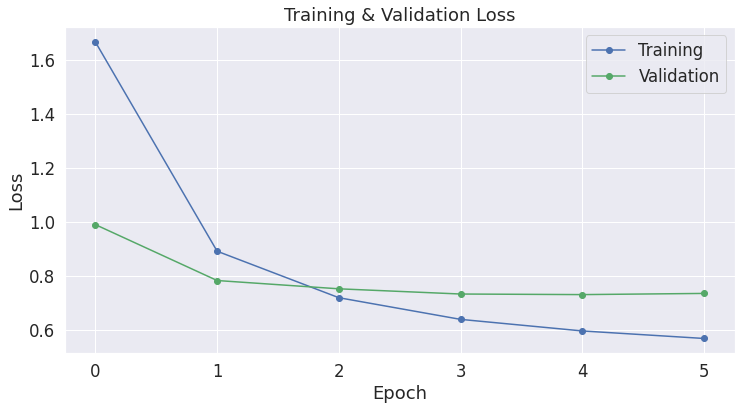

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_loss, 'b-o', label="Training")
plt.plot(val_loss, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5])

plt.show()

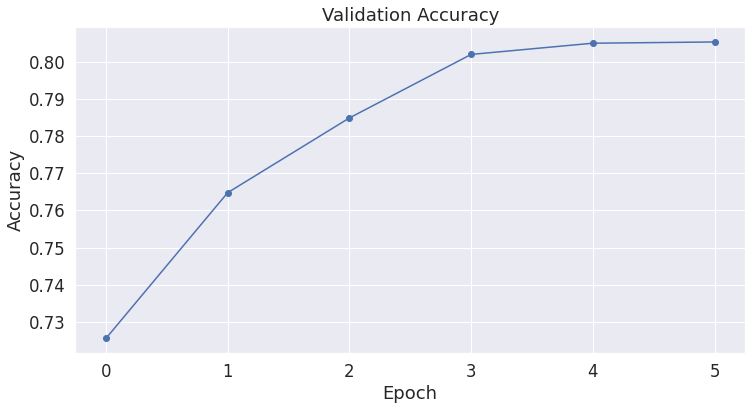

In [ ]:
plt.plot(val_accuracy, 'b-o', label="Training")

plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([0, 1, 2, 3, 4, 5])

plt.show()

In [ ]:
epoch = 5
PATH  = F"/content/gdrive/My Drive/Reddit/lr_2e_6_newsplit/model_epoch_%s.tar" % str(epoch)
state_dict = torch.load(PATH, map_location=device)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

### Results

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.67,0.99,0.73,0:49:03,0:01:55
2,0.89,0.78,0.76,0:49:00,0:01:55
3,0.72,0.75,0.78,0:49:00,0:01:55
4,0.64,0.73,0.80,0:48:59,0:01:55
5,0.60,0.73,0.80,0:49:01,0:01:55
6,0.57,0.74,0.81,0:49:00,0:01:56


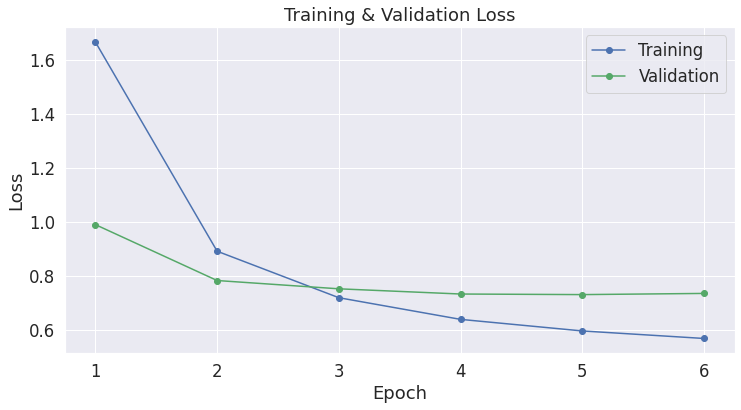

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

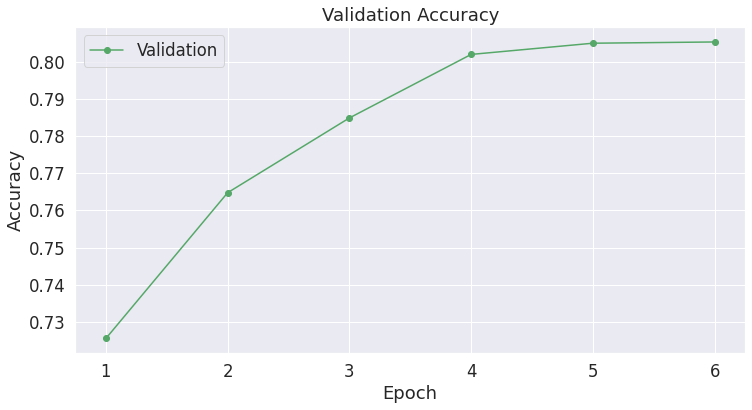

In [ ]:
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

### Save Model

In [ ]:
model_save_name = 'classifier_version4_lr1e_6_uncased.pt'
path = F"/content/gdrive/My Drive/Reddit/{model_save_name}" 
torch.save(model.state_dict(), path)

### Load Model

In [ ]:
model_save_name = 'classifier_version3_75_uncased.pt'
path = F"/content/gdrive/My Drive/Reddit/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Testing 

### Performing prepocessing steps on test data

In [ ]:
df_test['data'] = df_test['data'].apply(lambda x: x.replace("\n", "").replace("-", "").replace("....", "")) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test = df_test.drop(df_test[df_test['data']==''].index)

In [ ]:
threshold = 150
index_list, data = split_df(df_test, threshold)
df_test = df_test.drop(index_list)
df_test = df_test.append(data, True)

In [ ]:
i_test = filter_encoded(df_test,9)

In [ ]:
df_test = df_test.drop(i_test)

### Tokenizer

In [ ]:
sentence_test= df_test['data'].values
labels_test = df_test['target'].values

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentence_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)


prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Prediction

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,398 test sentences...
    DONE.


In [ ]:
def flat_accuracy_pred(preds, labels):
  preds_flat = np.hstack(np.array(list(map(lambda x: np.argmax(x, axis=1),preds)),dtype='object'))
  labels_flat = np.hstack(np.array(labels, dtype='object'))
  return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [ ]:
 flat_accuracy_pred(predictions, true_labels)

0.7754561506768688

### Metrics

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
preds_flat = np.hstack(np.array(list(map(lambda x: np.argmax(x, axis=1),predictions)),dtype='object')).astype(int)
labels_flat = np.hstack(np.array(true_labels, dtype='object')).astype(int)

In [ ]:
conf_matrix = confusion_matrix(labels_flat, preds_flat)

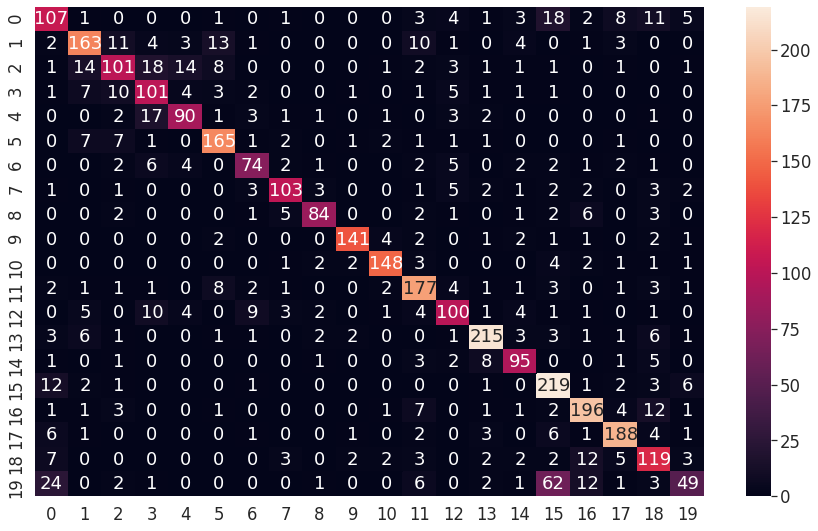

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d")

In [ ]:
pd.DataFrame(newsgroups.target_names)

,0
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball


In [ ]:
precision_score(labels_flat, preds_flat, average='macro')

0.7751572885592204

In [ ]:
recall_score(labels_flat, preds_flat, average='macro')

0.7646821819708798

In [ ]:
f1_score(labels_flat, preds_flat, average='macro')

0.7645994403679999